## ***Imports***

In [1]:
import pandas as pd
import numpy as np
import csv
import os
from datetime import datetime
import time
try:
  os.mkdir("result")
except:
  True
import matplotlib.pyplot as plt

## ***Pre processing***

In [13]:
def preprocess_data(df):
  df.drop(axis=1,columns=["country-year"],inplace=True)

  df["population"].describe()
  med=df["population"].describe()
  # print(med)
  # ma=df["population"].max()
  bins = [0, med["25%"], med["75%"], med["max"]]
  labels=["Low_population", "Medium_population", "High_population"]
  df["population"]=pd.cut(df["population"],bins=bins,labels=labels)

  med=df["suicides_no"].describe()
  # print(med)

  bins=[i*10 for i in range((int(med["75%"]+10))//10+2)]
  bins.insert(0,-1)
  # print(bins)
  bins.append(int(med["max"])+1)
  labels=["{}-{}".format(bins[i]+1,bins[i+1]) for i in range(len(bins)-1)]
  labels[-1]=">{})".format(bins[-2])
  # labels.insert(0,0)
  # print(labels)
  print(bins,labels,len(bins),len(labels))
  df["suicides_no"]=pd.cut(df["suicides_no"],bins=bins,labels=labels)
  med=df[' gdp_for_year ($) '].describe()
  # print(med)
  bins = [0, med["25%"], med["75%"], med["max"]]
  labels=["Low_income_country", "Medium_income_country", "High_income_country"]
  # df["population"]=pd.cut(df["population"],bins=bins,labels=labels)

  df[" gdp_for_year ($) "]=pd.cut(df[" gdp_for_year ($) "],bins=bins,labels=labels)

  med=df["gdp_per_capita ($)"].describe()
  # print(med)
  bins=[i*1000 for i in range(int(med["75%"]+1000)//1000+1)]
  bins.append(int(med["max"]))
  labels=["{}-{}".format(bins[i],bins[i+1]) for i in range(len(bins)-1)]
  # print(bins)
  labels[-1]=">{}".format(bins[-2])


  df["gdp_per_capita ($)"]=pd.cut(df["gdp_per_capita ($)"],bins=bins,labels=labels)
  df.drop(axis=1,columns=["suicides/100k pop"],inplace=True)
  df.drop(axis=1,columns=["HDI for year"],inplace=True)
  return df


##***computing cubes***

In [16]:
minsup_list=[100,250,500,750,1000]

##***Assuming that the cube fits into main memory***

In [17]:
def getcounts(data):
  # print(data)
  req=data[:,0]
  datacounts=[]
  k=0
  if(len(req)==1):
    return [1]
  for i in range(len(req)-1):
    k+=1
    if(req[i]!=req[i+1]):
      datacounts.append(k)
      k=0
  datacounts.append(k+1)
  return datacounts

def getcounts_page(file,attr):
  temp=pd.read_csv(file)
  req=temp[attr]
  datacounts=[]
  k=0
  if(len(req)==1):
    return [1]
  for i in range(len(req)-1):
    k+=1
    if(req[i]!=req[i+1]):
      datacounts.append(k)
      k=0
  datacounts.append(k+1)
  return datacounts

def compute(data,l):
  dim=data.shape[1]
  if(dim==0):
    s.append(l.copy())
    s[-1].append(len(data))
    return
  # print(data[:,0])
  data=data[data[:,0].argsort()]

  datacounts=getcounts(data)
  k=0
  for i in range(len(datacounts)):
    c=datacounts[i]
    if(c>=minsup):
      l.append(data[k,0])
      compute(data[k:k+c,1:],l.copy())
      l.pop()
    k+=c
  l.append("ALL")
  compute(data[:,1:],l.copy())
  l.pop()
runtimes=[]
numcubes=[]
df=pd.read_csv("master.csv")
df=preprocess_data(df)
for i in range(len(minsup_list)):
  dup=df
  vals=dup.values
  vals=vals[vals[:,0].argsort()]
  dup.sort_values("country",inplace=True)
  s=[]
  dic={}
  l=[]
  start=time.time()
  minsup=minsup_list[i]
  compute(vals,l)
  end= time.time()-start
  runtimes.append(end)
  numcubes.append(len(s))
  break
y=s
cols=list(dup.columns)
cols.append("Count")
result=pd.DataFrame(y)
result.columns=cols
result.to_csv("result/result.csv")
print(len(y))

[-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 22339] ['0-0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-120', '121-130', '131-140', '141-150', '>150)'] 18 17
9388


In [18]:
print(runtimes)
print(numcubes)

[3.0680007934570312]
[9388]


##***out of memory assumption***

##***External merge sort***

In [19]:
def merge_files(filename,fp1,fp2,attr,start,mid,end):
  t1=mid-start+1
  t2=end-mid
  p1=0
  p2=0
  with open(filename, "w") as f:
      reader = csv.writer(f)
      with open(fp1) as f1:
        r1=csv.reader(f1,delimiter=",")
        with open(fp2) as f2:
          r2=csv.reader(f2,delimiter=",")
          cols=next(r1)
          next(r2)
          reader.writerow(cols)
          val1=next(r1)
          val2=next(r2)
          condition=""
          if(str(val1[attr]).isnumeric()):
            condition="float(val1[attr])<=float(val2[attr])"
          else:
            condition="val1[attr]<=val2[attr]"
          while(p1<t1 and p2<t2):
            if(eval(condition)):
              reader.writerow(val1)
              p1+=1
              if(p1>=t1):
                break
              val1=next(r1)
            else:
              reader.writerow(val2)
              p2+=1
              if(p2>=t2):
                break
              val2=next(r2)
          
          while(p1<t1):
            reader.writerow(val1)
            p1+=1
            if(p1>=t1):
              break
            val1=next(r1)
          while(p2<t2):
            reader.writerow(val2)
            p2+=1
            if(p2>=t2):
              break
            val2=next(r2)
        # print(p1,t1,p2,t2)

In [20]:
def external_merge_sort(filename,start,end,attr,columns,rows):
  if(end-start<rows):
    temp=pd.read_csv(filename)
    temp.sort_values(attr,inplace=True)
    temp.set_index(temp.columns[0],inplace=True)
    temp.to_csv(filename)

  else:
    mid=(start+end)//2
    f1=[]
    f2=[]
    x=f1
    with open(filename) as f:
      reader = csv.reader(f, delimiter=",")
      next(reader)
      ind =0
      for i,line in enumerate(reader):
        f1.append(line)
        if(i==mid-start):
          break
      
      for i,line in enumerate(reader):
        f2.append(line)

    fp="{}_{}_{}.csv"
    fp1=fp.format(start,mid,attr)
    fp2=fp.format(mid+1,end,attr)
    f1=pd.DataFrame(f1)
    f1.columns=columns
    f1.set_index(f1.columns[0],inplace=True)
    f1.to_csv(fp1)
    external_merge_sort(fp1,start,mid,attr,columns,rows)
    f2=pd.DataFrame(f2)
    f2.columns=columns
    f2.set_index(f2.columns[0],inplace=True)
    f2.to_csv(fp2)
    external_merge_sort(fp2,mid+1,end,attr,columns,rows)
    merge_files(filename,fp1,fp2,list(columns).index(attr),start,mid,end)
    os.remove(fp1)
    os.remove(fp2)

## ***Rough stuff : ignore***

In [ ]:
# df=pd.read_csv("master.csv")
# external_merge_sort("master.csv",0,27819,"country",df.columns,830)

# un=df["country"].unique()
# orig={}
# for i in range(len(un)):
#   orig.update({un[i]:len(df[df.country==un[i]])})



In [ ]:
df=pd.read_csv("master.csv")
found=df["country"].unique()
new={}
for i in range(len(found)):
  new.update({found[i]:len(df[df.country==found[i]])})

## ***Table class***

In [21]:
# approxiamting each tuple of a table is of fixed length
# approximating block size to store 10000 entries of a table instead of hardcoding it to x bytes
# so no of row that could be stored in a block = floor(10000/(no of columns))
global block_size
block_size=2 # in (10k entries)
global pagenumber
pagenumber=0
global pageids
pageids={}
class Table:
  def __init__(self,file):
    self.filename=file
    # pageid.update({file:self.filename})
    # pagenumber+=1
    rowCount=0
    temp=pd.read_csv(self.filename,nrows=1)
    self.numColumns=len(temp.columns)
    self.columns=temp.columns
    with open(self.filename) as f:
      reader = csv.reader(f, delimiter=",")
      for i, line in enumerate(reader):
        rowCount+=1
    self.numRows=rowCount
    self.numRowsinBlock=block_size*1000//self.numColumns

  def partition(self,attr):

    total=0
    self.numRowsinBlock=block_size*1000//self.numColumns
    # print(self.numRowsinBlock)
    # print(self.numColumns,self.numRows)
    block=[]
    # print(self.numRows)
    # print()
    index=list(self.columns).index(attr)
    external_merge_sort(self.filename,0,self.numRows-2,attr,self.columns,self.numRowsinBlock)
    c=getcounts_page(self.filename,attr)
    with open(self.filename) as f:
      reader = csv.reader(f,delimiter=",")
      for i in range(len(c)):
        self.write_partition(self.filename,attr,c[i],i,reader)
        # self.make_pages(self.filename,attr,c[i],i,reader)
    return c
  
  def get_partition_value(self,attr):
    with open(self.filename,"r") as f:
      reader=csv.reader(f,delimiter=",")
      next(reader)
      index=list(self.columns).index(attr)
      for i,line in enumerate(reader):
        val=line[index]
        break
    return val
 
  def write_partition(self,filename,attr,count,i,reader):
      global pagenumber
      global pageid
      if(i==0):
        next(reader)
      with open("page_{}".format(pagenumber).format(filename,attr,i),"w") as f:
        writer=csv.writer(f)
        pageids.update({"{}_{}_{}".format(filename,attr,i):"page_{}".format(pagenumber)})
        pagenumber+=1
        index=list(self.columns).index(attr)
        writer.writerow(list(self.columns)[index:])
        ind=0
        for i ,line in enumerate(reader):
          writer.writerow(line[index:])
          ind+=1
          if(ind==count):
            break
      
  # def make_pages(self,filename,attr,count,i,reader):
  #   block=[]
  #   filestring="{}_{}_{}".format(filename,attr,i)
  #   with open(filestring,"r") as f1:
  #     r1=csv.reader(f1)
  #     ind=0
  #     next(r1)
  #     pageindex=0
  #     for i,line in enumerate(r1):
  #       block.append(line)
  #       if(len(block)==self.numRowsinBlock):
  #         newpage=Page(block,filestring,pageindex,list(self.columns))
  #         block=[]
  #         pageindex+=1
  #     if(len(block)!=0):
  #        newpage=Page(block,filestring,pageindex,list(self.columns))
  #        block=[]
  def getvalues(self):
    df=pd.read_csv(self.filename)
    return df.values

  # def getpage(self):
  #   p=Page(0,self.filename)
  #   self.curr=0
  #   return p.read_page()
  
  # def getnextpage(self):
  #   self.curr+=1
  #   if(self.curr<self.block_no):
  #     p=Page(self.curr,self.filename)
  #     return p.read_page()
  #   else:
  #     return False

# class Page(Table):
#   def __init__(self,block,filestring,pageindex,columns):
#     self.filename=filestring+"_page"+str(pageindex)
#     self.pageindex=pageindex
#     temp=pd.DataFrame(block)
#     temp.columns=columns
#     self.numColumn=len(columns)
#     self.numRows=len(block)
#     # print(self.numRows,"***")
#     temp.set_index(columns[0],inplace=True)
#     temp.to_csv(self.filename)

#   def read_page(self):
#     df=pd.read_csv(self.filename[:-3]+"_"+str(self.pageindex)+".csv")
#     return df

##***Buc Algorithm***

In [22]:
global depth
depth=0
def compute(data,l,attr,vals):
  global pagenumber
  global pageid
  global depth
  # if(depth==300):
  #   return
  # depth+=1

  if(attr==None):
    s.append(l.copy())
    if(len(vals)==0):
      s[-1].append(data.numRows-1)
    else:
      s[-1].append(len(vals))
    return 

  temp=[]

  if(len(vals)==0):
    if(data.numRows-1>data.numRowsinBlock):
      datacounts=data.partition(attr)
    else:
      vals=data.getvalues()
      # print(list(data.columns),attr)
      index=list(data.columns).index(attr)
      vals=vals[:,index:]
      vals=vals[vals[:,0].argsort()]
      datacounts=getcounts(vals)
      temp=vals.copy()

  else:
    vals=vals[vals[:,0].argsort()]
    datacounts=getcounts(vals)
    temp=vals.copy()

  k=0

  for i in range(len(datacounts)):
    c=datacounts[i]
    if(len(vals)==0):
      if(c>=minsup):
        tab=Table(pageids["{}_{}_{}".format(data.filename,attr,i)])
        l.append(tab.get_partition_value(attr))
        # print(c,data.numRows-1,l[0])
        index=list(data.columns).index(attr)
        
        if(data.numColumns>index+1):
          compute(tab,l,list(data.columns)[index+1],[])
        else:
          compute(tab,l,None,[])
        l.pop()
    else:
      if(c>=minsup):
        # print(c,len(vals))
        l.append(vals[k,0])
        if(vals.shape[1]>1):
          compute(data,l,attr,vals[k:k+c,1:])
        else:
          compute(data,l,None,vals[k:k+c,1:])
        l.pop()
    k+=c
  l.append("ALL")
  index=list(data.columns).index(attr)
  if(len(vals)==0):
    if(data.numColumns>index+1):
      compute(data,l,list(data.columns)[index+1],[])
    else:
      compute(data,l,None,[])
  else:
    if(vals.shape[1]>1):
      compute(data,l,attr,vals[:,1:])
    else:
      compute(data,l,None,vals[:,1:])

  l.pop()


In [23]:
df=pd.read_csv("master.csv")
df=preprocess_data(df)
df.set_index(list(df.columns)[0],inplace=True)
df.to_csv("preprocessed.csv")

[-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 22339] ['0-0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-120', '121-130', '131-140', '141-150', '>150)'] 18 17


## ***Driver code***

In [24]:
numcubes_paging=[]
runtimes_paging=[]

l=[]
pageids={}
pagenumber=0
s=[]
st=time.time()
minsup=minsup_list[0]
tab=Table("preprocessed.csv")
compute(tab,l,list(tab.columns)[0],[])
end=time.time()-st

  # numcubes_paging.append(len(s))
  # runtimes_paging.append(end)

##***Generating data  for visualizations (varying support count and block size)***

In [ ]:
numcubes_paging=[]
runtimes_paging=[]
for i in range(len(minsup_list)):
  l=[]
  pageids={}
  pagenumber=0
  s=[]
  st=time.time()
  minsup=minsup_list[i]
  tab=Table("preprocessed.csv")
  compute(tab,l,list(tab.columns)[0],[])
  end=time.time()-st

  numcubes_paging.append(len(s))
  runtimes_paging.append(end)


In [ ]:
block_sizes=[2,5,10,12,15]
numcubes_paging=[]
runtimes_paging=[]
for i in range(len(block_sizes)):
  l=[]
  pageids={}
  pagenumber=0
  s=[]
  st=time.time()
  block_size=block_sizes[i]
  # minsup=minsup_list[i]
  tab=Table("preprocessed.csv")
  compute(tab,l,list(tab.columns)[0],[])
  end=time.time()-st
  print(end,i)

  numcubes_paging.append(len(s))
  runtimes_paging.append(end)


187.06388449668884 0
119.2845389842987 1
84.23395848274231 2
79.79100036621094 3
60.215980768203735 4


Text(0, 0.5, 'Runtime in secs')

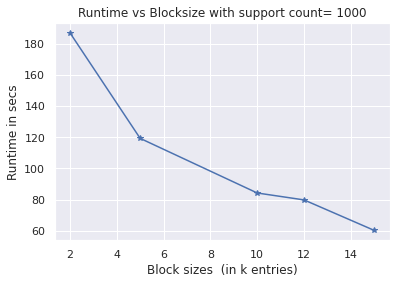

In [ ]:
sns.set()
plt.title("Runtime vs Blocksize with support count= 1000")
plt.plot(block_sizes,runtimes_paging,marker="*")
plt.xlabel("Block sizes  (in k entries)")
plt.ylabel("Runtime in secs")


In [ ]:
print(numcubes)
print(runtimes_paging)

[9388, 2810, 1045, 585, 402]
[227.4637360572815, 215.38430070877075, 192.93599438667297, 180.17787981033325, 168.13243126869202]


Text(0, 0.5, 'RUntime in secs')

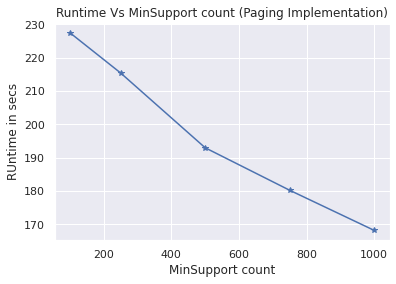

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.title("Runtime Vs MinSupport count (Paging Implementation)")
plt.plot(minsup_list,runtimes_paging,marker="*")
plt.xlabel("MinSupport count")
plt.ylabel("RUntime in secs")
# plt.plot(runtimes_paging)

Text(0, 0.5, 'RUntime in secs')

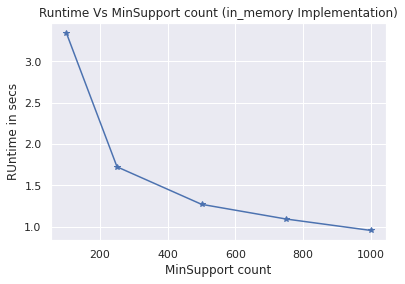

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.title("Runtime Vs MinSupport count (in_memory Implementation)")
plt.plot(minsup_list,runtimes,marker="*")
plt.xlabel("MinSupport count")
plt.ylabel("RUntime in secs")
# plt.plot(runtimes_paging)

Text(0, 0.5, 'Number of cubes')

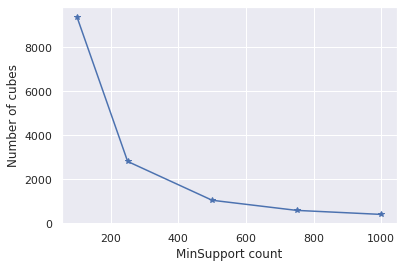

In [ ]:
plt.plot(minsup_list,numcubes_paging,marker="*")
plt.xlabel("MinSupport count")
plt.ylabel("Number of cubes")

In [ ]:
result=pd.DataFrame(s)

In [ ]:
cols=list(tab.columns)
cols.append("Count")
result.columns=cols
result.to_csv("result/result.csv")

## ***Test***

In [25]:
for i in range(len(y)):
  y[i][1]=str(y[i][1])
  s[i][1]=str(s[i][1])

In [26]:
for i in range(len(y)):
  if(y[i]!=s[i]):
    print("******")